# <center> Классификация персонажей Симпсонов. </center>

_________________________________________

## Содержание работы.
### 1. [Установка зависимостей](#chapter1)
### 2. [Загрузка датасета](#chapter2)
### 3. [Бейзлайн](#chapter3)
#### 3.1. [Начальные гиперпараметры](#chapter3.1)
#### 3.2. [Меняем гиперпараметры обучения](#chapter3.2)
### 4. [ResNet](#chapter4)
#### 4.1. [Замороженный ResNet18](#chapter4.1)
#### 4.2. [Разморозка части ResNet18](#chapter4.2)
#### 4.3. [ResNet50 с размороженным layer4](#chapter4.3)
### 5. [Работа с данными. Агументация](#chapter5)
#### 5.1. [Исследование распределения классов](#chapter5.1)
#### 5.2. [Дополнение редких классов при помощи аугментации](#chapter5.2)
#### 5.3. [Обучение ResNet50 на дополненном датасете](#chapter5.3)
### 6. [Анализ результатов. Сабмит на каггл.](#chapter6)

## 1. Установка зависимостей. 

In [1]:
import torch

import numpy as np



train_on_gpu = torch.cuda.is_available()



if not train_on_gpu:

    print('CUDA is not available.  Training on CPU ...')

else:

    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL

print(PIL.__version__)

10.4.0


In [3]:
!nvidia-smi

import torch

torch.cuda.is_available()

Thu Nov 14 18:40:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [4]:
import pickle

import numpy as np

from skimage import io



from tqdm import tqdm, tqdm_notebook

from PIL import Image

from pathlib import Path


import torchvision

from torchvision import transforms

from multiprocessing.pool import ThreadPool

from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn



from matplotlib import colors, pyplot as plt

%matplotlib inline



# в sklearn не все гладко, чтобы в colab удобно выводить картинки

# мы будем игнорировать warnings

import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


## <a id="gavno"> 2. Работа с датасетом. </a>

In [5]:
# разные режимы датасета

DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px

RESCALE_SIZE = 224

# работаем на видеокарте

DEVICE = torch.device("cuda")

In [6]:
class SimpsonsDataset(Dataset):

    """

    Датасет с картинками, который паралельно подгружает их из папок

    производит скалирование и превращение в торчевые тензоры

    """

    def __init__(self, files, mode: str, transform: torchvision.transforms.Compose):

        super().__init__()

        # список файлов для загрузки

        self.files = sorted(files)

        # режим работы

        self.mode = mode

        # этапы преобразования изображений к тензорам
        # поле для возможности создания аугментированного датасета
        self.transform = transform



        if self.mode not in DATA_MODES:

            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")

            raise NameError



        self.len_ = len(self.files)



        self.label_encoder = LabelEncoder()



        if self.mode != 'test':

            self.labels = [path.parent.name for path in self.files]

            self.label_encoder.fit(self.labels)



            with open('label_encoder.pkl', 'wb') as le_dump_file:

                  pickle.dump(self.label_encoder, le_dump_file)



    def __len__(self):

        return self.len_



    def load_sample(self, file):

        image = Image.open(file)

        image.load()

        return image


    
    def _prepare_sample(self, image):

        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return np.array(image)



    def __getitem__(self, index):

        x = self.load_sample(self.files[index])

        x = self._prepare_sample(x)

        x = np.array(x / 255, dtype='float32')

        x = self.transform(x)

        if self.mode == 'test':

            return x

        else:

            label = self.labels[index]

            label_id = self.label_encoder.transform([label])

            y = label_id.item()

            return x, y

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    """Imshow для тензоров"""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)

    if title is not None:

        plt_ax.set_title(title)

    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('/kaggle/input/simpsons/train/simpsons_dataset/')

TEST_DIR = Path('/kaggle/input/simpsons/testset/testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels, random_state=42)

In [11]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

val_dataset = SimpsonsDataset(val_files, mode='val', transform=transform)

Давайте посмотрим на наших героев внутри датасета.

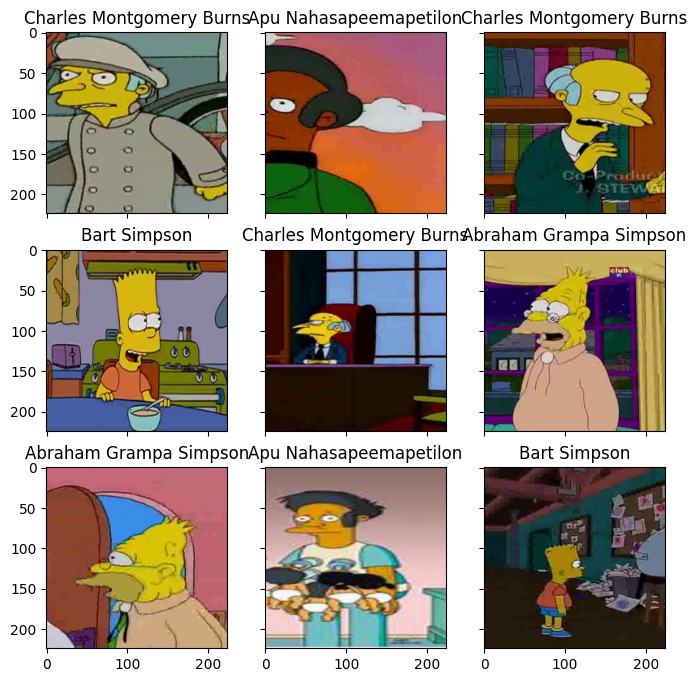

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)

## 3. Бейзлайн.


*Описание слоев*:


1. размерность входа: 3x224x224

2. размерности после слоя:  8x111x111

3. 16x54x54

4. 32x26x26

5. 64x12x12

6. выход: 96x5x5


In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [14]:
# Кастомная сверточная нейронная сеть.
# (Добавлены BatchNorm слои)

class SimpleCnn(nn.Module):



    def __init__(self, n_classes):

        super().__init__()

        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),

            nn.BatchNorm2d(8),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv2 = nn.Sequential(

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            
            nn.BatchNorm2d(16),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv3 = nn.Sequential(

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),

            nn.BatchNorm2d(32),            

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv4 = nn.Sequential(

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),

            nn.BatchNorm2d(64),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv5 = nn.Sequential(

            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),

            nn.BatchNorm2d(96),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )



        self.out = nn.Linear(96 * 5 * 5, n_classes)





    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        x = self.conv4(x)

        x = self.conv5(x)



        x = x.view(x.size(0), -1)

        logits = self.out(x)

        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):

    running_loss = 0.0

    running_corrects = 0

    processed_data = 0



    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        optimizer.zero_grad()



        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_data += inputs.size(0)



    train_loss = running_loss / processed_data

    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    processed_size = 0



    for inputs, labels in val_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)



        with torch.set_grad_enabled(False):

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)



        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [15]:
def train(train_dataset, val_dataset, model, epochs, batch_size, opt=None, lr_scheduler_gamma=1.0):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"



    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        if opt==None:
            opt = torch.optim.Adam(model.parameters())

        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=lr_scheduler_gamma)

        criterion = nn.CrossEntropyLoss()



        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)



            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))

            # Меняем lr
            lr_scheduler.step()


            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\

                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    # Отрисуем графики лосса
    loss, acc, val_loss, val_acc = zip(*history)
    
    plt.figure(figsize=(15, 9))

    plt.plot(loss, label="train_loss")

    plt.plot(val_loss, label="val_loss")

    plt.legend(loc='best')

    plt.xlabel("epochs")

    plt.ylabel("loss")

    plt.show()

    return history

In [16]:
def predict(model, test_loader):

    with torch.no_grad():

        logits = []



        for inputs in test_loader:

            inputs = inputs.to(DEVICE)

            model.eval()

            outputs = model(inputs).cpu()

            logits.append(outputs)



    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [17]:
def predict_one_sample(model, inputs, device=DEVICE):

    """Предсказание, для одной картинки"""

    with torch.no_grad():

        inputs = inputs.to(device)

        model.eval()

        logit = model(inputs).cpu()

        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs

In [18]:
from sklearn.metrics import f1_score

def eval_f1_score(model, dataset):
    idxs = list(range(len(dataset)))
    
    # Получаем список всех изображений датасета в виде тензоров
    imgs = [dataset[id][0].unsqueeze(0) for id in idxs]
    
    # Считаем вероятности принадлежности классам
    probs_ims = predict(model, imgs)

    
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    
    # Получаем метки предсказанных классов
    y_pred = np.argmax(probs_ims,-1)
    # Правильные метки классов
    actual_labels = [dataset[id][1] for id in idxs]
    
    f1 = f1_score(actual_labels, y_pred, average='micro')

    return f1

### 3.1. Бейзлайн с умолчательными параметрами.

In [21]:
# Параметры обучения
NUM_EPOCHS = 5
BATCH_SIZE=64
LEARNING_RATE=0.001
LR_GAMMA=1.0

In [22]:
n_classes = len(np.unique(train_val_labels))

default_simple_cnn = SimpleCnn(n_classes).to(DEVICE)

print("we will classify :{}".format(n_classes))

print(default_simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [23]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val', transform=transform)



train_dataset = SimpsonsDataset(train_files, mode='train', transform=transform)

__Обучение:__

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.7542200625888162


epoch:  20%|██        | 1/5 [03:41<14:46, 221.59s/it]


Epoch 001 train_loss: 1.7542     val_loss 1.4060 train_acc 0.5321 val_acc 0.6288
loss 1.0417840719617881


epoch:  40%|████      | 2/5 [06:03<08:43, 174.42s/it]


Epoch 002 train_loss: 1.0418     val_loss 0.9552 train_acc 0.7088 val_acc 0.7438
loss 0.688110379331681


epoch:  60%|██████    | 3/5 [08:28<05:22, 161.19s/it]


Epoch 003 train_loss: 0.6881     val_loss 0.8213 train_acc 0.8046 val_acc 0.7801
loss 0.4791997091957274


epoch:  80%|████████  | 4/5 [10:48<02:32, 152.75s/it]


Epoch 004 train_loss: 0.4792     val_loss 0.7473 train_acc 0.8609 val_acc 0.8055
loss 0.33762924772659314


epoch: 100%|██████████| 5/5 [13:09<00:00, 157.81s/it]



Epoch 005 train_loss: 0.3376     val_loss 0.7129 train_acc 0.9008 val_acc 0.8275


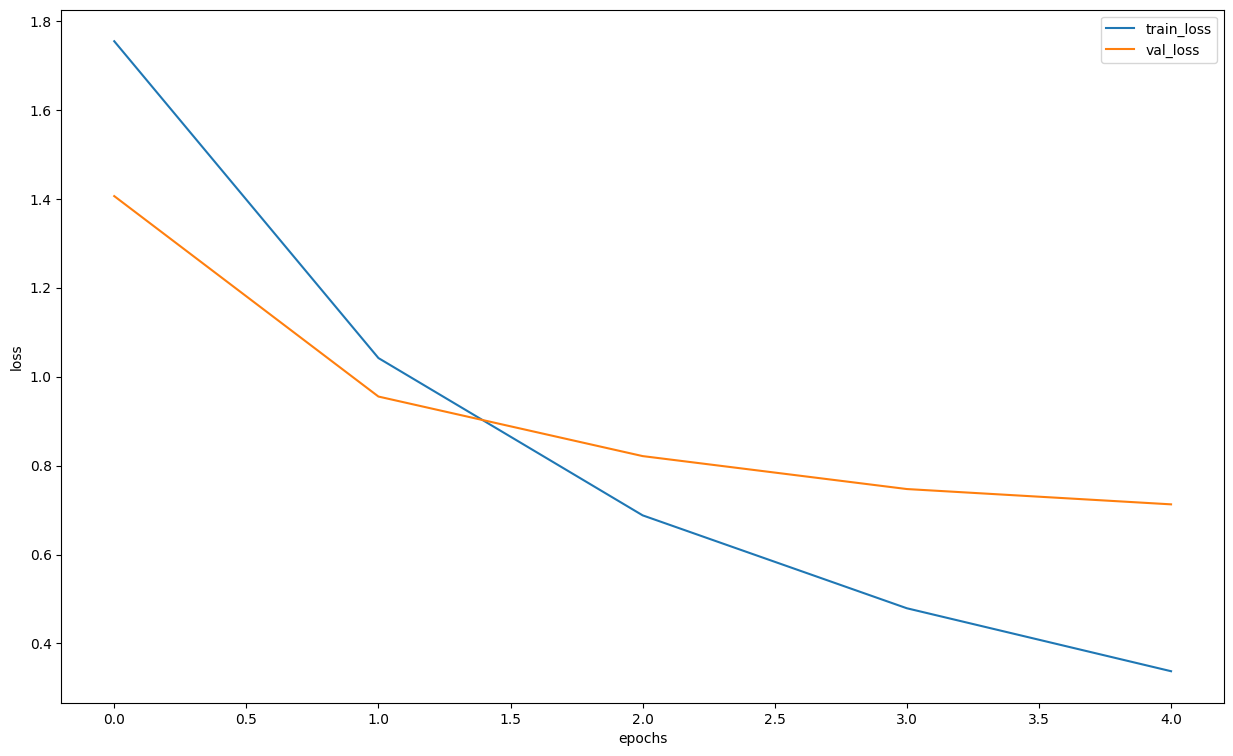

In [24]:
history = train(train_dataset, 
                val_dataset, 
                model=default_simple_cnn, 
                epochs=NUM_EPOCHS, 
                batch_size=BATCH_SIZE, 
                lr=LEARNING_RATE, 
                lr_scheduler_gamma=LR_GAMMA)

__Оценка:__

In [25]:
eval_f1_score(default_simple_cnn, val_dataset)

0.827474207107375

### 3.2. Пробуем другой набор гиперпараметров.

In [26]:
# Параметры обучения
NUM_EPOCHS = 7
BATCH_SIZE=128
LEARNING_RATE=0.005
LR_GAMMA=0.8

In [27]:
new_simple_cnn = SimpleCnn(n_classes).to(DEVICE)

__Обучение:__

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.595197507921879


epoch:  14%|█▍        | 1/7 [02:15<13:31, 135.27s/it]


Epoch 001 train_loss: 2.5952     val_loss 1.7331 train_acc 0.3721 val_acc 0.5466
loss 1.4298313315244713


epoch:  29%|██▊       | 2/7 [04:29<11:13, 134.78s/it]


Epoch 002 train_loss: 1.4298     val_loss 1.2493 train_acc 0.6104 val_acc 0.6622
loss 0.9611618243757271


epoch:  43%|████▎     | 3/7 [06:42<08:55, 133.97s/it]


Epoch 003 train_loss: 0.9612     val_loss 0.9957 train_acc 0.7337 val_acc 0.7310
loss 0.6687758227477932


epoch:  57%|█████▋    | 4/7 [08:49<06:33, 131.03s/it]


Epoch 004 train_loss: 0.6688     val_loss 0.9296 train_acc 0.8117 val_acc 0.7583
loss 0.4599888698524241


epoch:  71%|███████▏  | 5/7 [10:57<04:19, 129.90s/it]


Epoch 005 train_loss: 0.4600     val_loss 0.8589 train_acc 0.8688 val_acc 0.7889
loss 0.30144505593357396


epoch:  86%|████████▌ | 6/7 [13:05<02:09, 129.36s/it]


Epoch 006 train_loss: 0.3014     val_loss 0.8200 train_acc 0.9113 val_acc 0.8059
loss 0.20440138386566856


epoch: 100%|██████████| 7/7 [15:12<00:00, 130.35s/it]



Epoch 007 train_loss: 0.2044     val_loss 0.8915 train_acc 0.9406 val_acc 0.8149


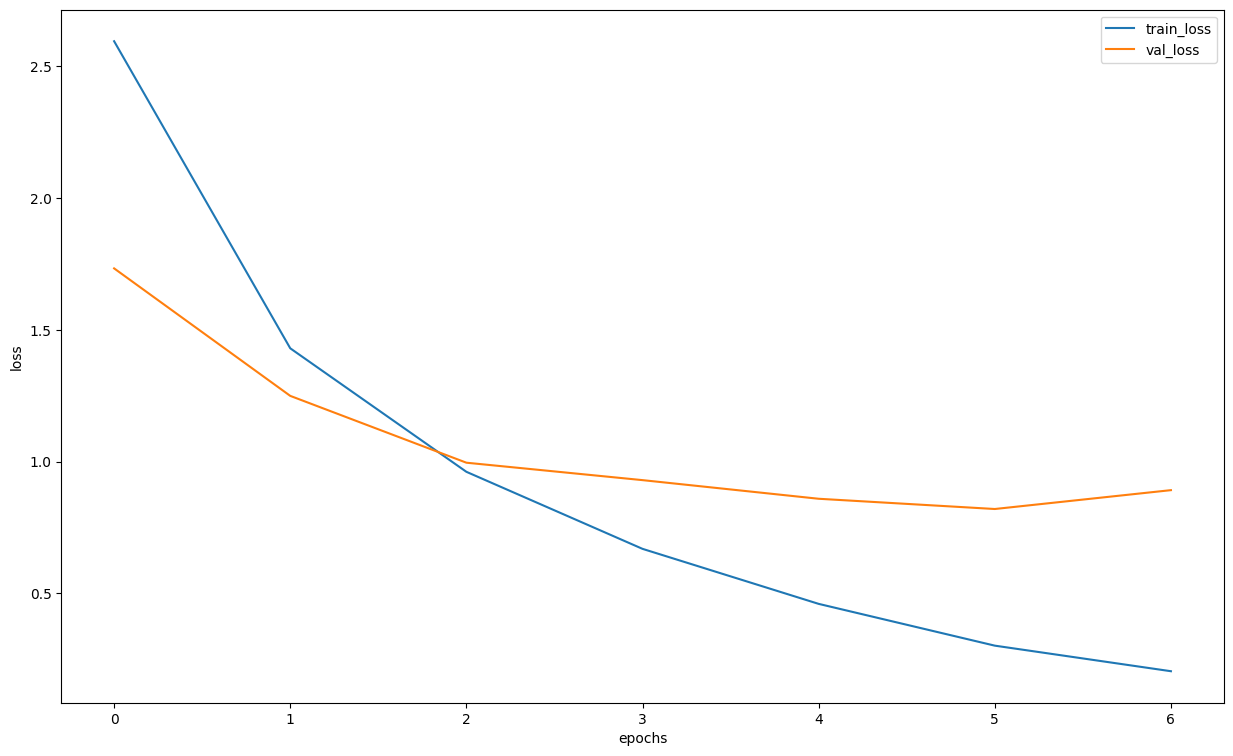

In [28]:
history = train(train_dataset, 
                val_dataset, 
                model=new_simple_cnn, 
                epochs=NUM_EPOCHS, 
                batch_size=BATCH_SIZE, 
                lr=LEARNING_RATE, 
                lr_scheduler_gamma=LR_GAMMA)

__Оценка:__

In [29]:
eval_f1_score(new_simple_cnn, val_dataset)

0.8148643484906382

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

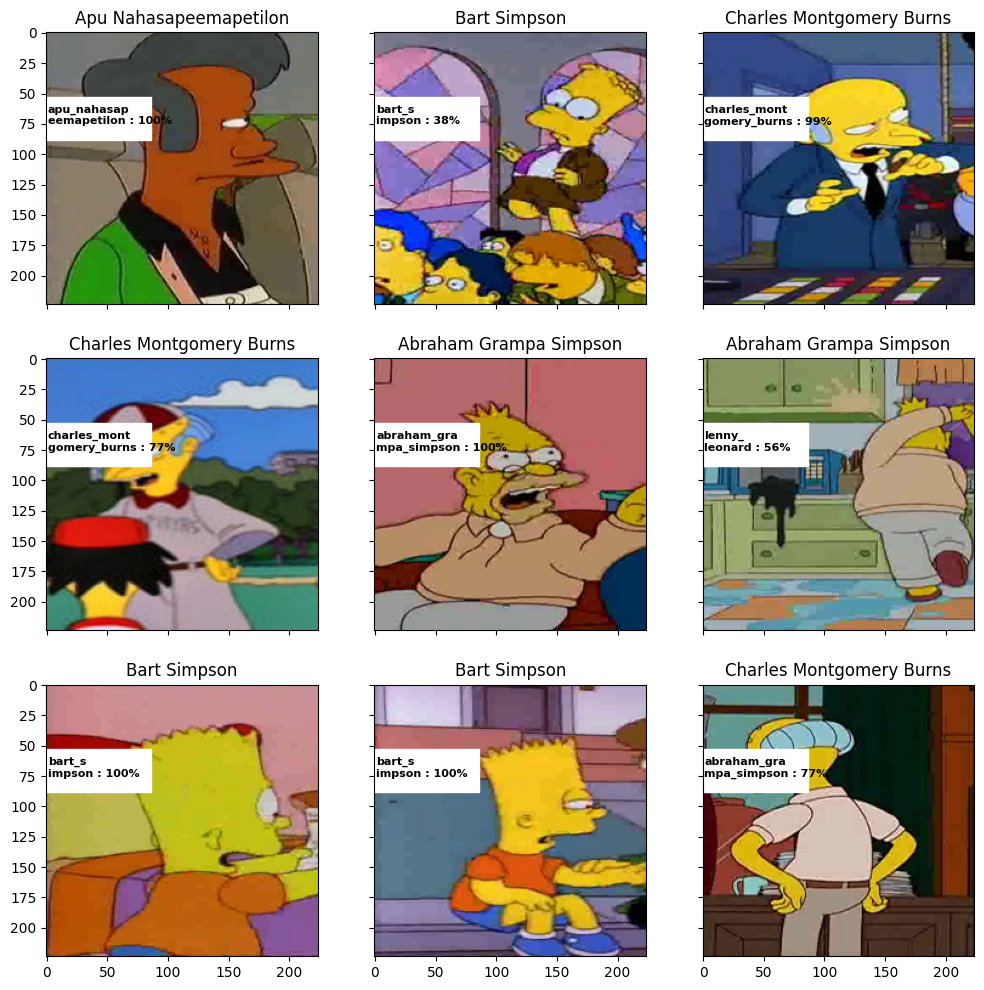

In [31]:
import matplotlib.patches as patches

from matplotlib.font_manager import FontProperties


label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))







    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)



    actual_text = "Actual : {}".format(img_label)



    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))

    font0 = FontProperties()

    font = font0.copy()

    font.set_family("fantasy")

    prob_pred = predict_one_sample(default_simple_cnn, im_val.unsqueeze(0))

    predicted_proba = np.max(prob_pred)*100

    y_pred = np.argmax(prob_pred)



    predicted_label = label_encoder.classes_[y_pred]

    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]

    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)



    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,

                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## 4. ResNet

In [32]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.1. Замороженный ResNet18.

In [50]:
# Параметры обучения
NUM_EPOCHS = 10
BATCH_SIZE=64
LEARNING_RATE=0.01
LR_GAMMA=0.6

In [51]:
freezed_resnet = torchvision.models.resnet18(pretrained=True)

for param in freezed_resnet.parameters():
    param.requires_grad = False

freezed_resnet.fc = nn.Linear(512, n_classes)

freezed_resnet = freezed_resnet.to(DEVICE)

optimizer = torch.optim.Adam(freezed_resnet.fc.parameters(), lr=LEARNING_RATE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.7291641931061805


epoch:  10%|█         | 1/10 [02:16<20:26, 136.32s/it]


Epoch 001 train_loss: 1.7292     val_loss 1.3030 train_acc 0.5941 val_acc 0.6597
loss 0.8884685240746213


epoch:  20%|██        | 2/10 [04:28<17:52, 134.07s/it]


Epoch 002 train_loss: 0.8885     val_loss 0.9504 train_acc 0.7561 val_acc 0.7396
loss 0.6893193024884015


epoch:  30%|███       | 3/10 [06:42<15:36, 133.83s/it]


Epoch 003 train_loss: 0.6893     val_loss 0.8669 train_acc 0.8043 val_acc 0.7661
loss 0.6026496113664109


epoch:  40%|████      | 4/10 [08:54<13:18, 133.14s/it]


Epoch 004 train_loss: 0.6026     val_loss 0.8255 train_acc 0.8339 val_acc 0.7734
loss 0.5469610619103804


epoch:  50%|█████     | 5/10 [11:11<11:11, 134.38s/it]


Epoch 005 train_loss: 0.5470     val_loss 0.8191 train_acc 0.8509 val_acc 0.7728
loss 0.524137006446703


epoch:  60%|██████    | 6/10 [13:26<08:58, 134.67s/it]


Epoch 006 train_loss: 0.5241     val_loss 0.8070 train_acc 0.8593 val_acc 0.7816
loss 0.5057603384808481


epoch:  70%|███████   | 7/10 [15:38<06:42, 134.03s/it]


Epoch 007 train_loss: 0.5058     val_loss 0.7938 train_acc 0.8654 val_acc 0.7822
loss 0.49654557674703675


epoch:  80%|████████  | 8/10 [17:51<04:27, 133.66s/it]


Epoch 008 train_loss: 0.4965     val_loss 0.7902 train_acc 0.8690 val_acc 0.7816
loss 0.48817760364683854


epoch:  90%|█████████ | 9/10 [20:06<02:14, 134.10s/it]


Epoch 009 train_loss: 0.4882     val_loss 0.7879 train_acc 0.8726 val_acc 0.7818
loss 0.48480689701582036


epoch: 100%|██████████| 10/10 [22:20<00:00, 134.10s/it]



Epoch 010 train_loss: 0.4848     val_loss 0.7881 train_acc 0.8738 val_acc 0.7801


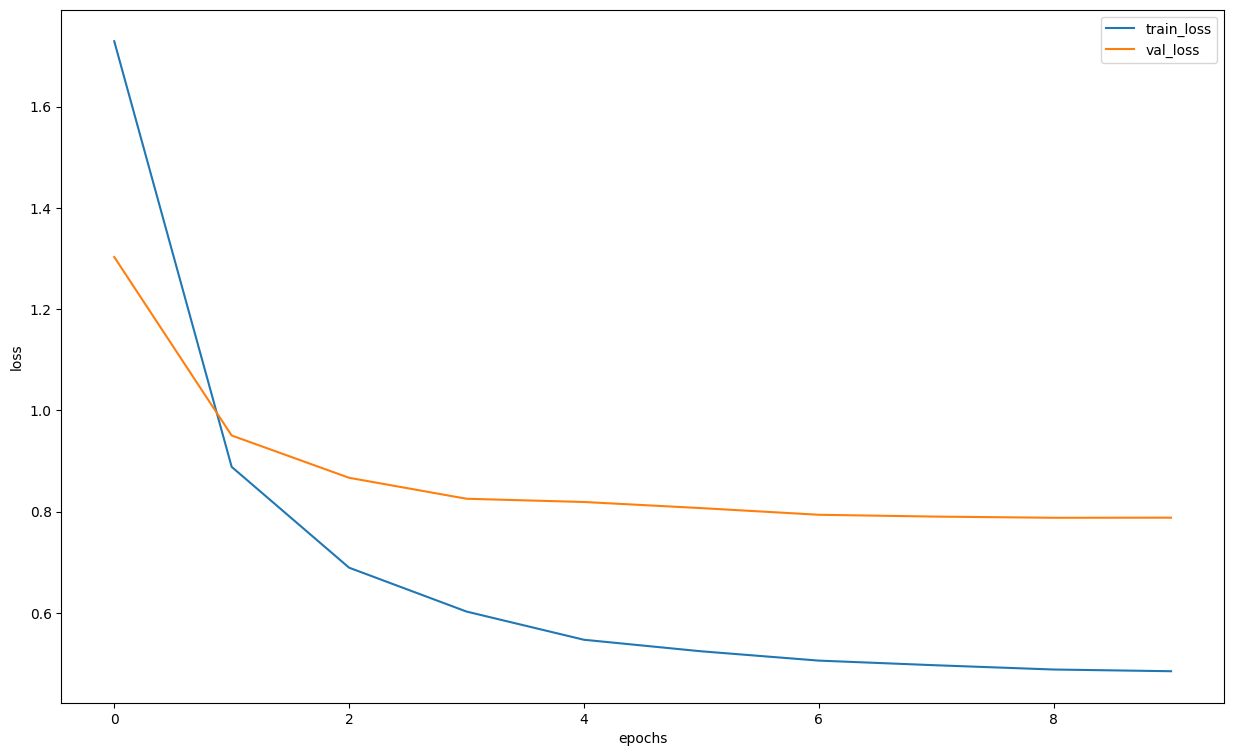

In [52]:
history = train(train_dataset, val_dataset, freezed_resnet, NUM_EPOCHS, BATCH_SIZE, optimizer, LR_GAMMA)

In [53]:
eval_f1_score(freezed_resnet, val_dataset)

0.7800917080626671

### 4.2. ResNet18 с размороженными последними слоями.

In [67]:
# Параметры обучения
NUM_EPOCHS = 5
BATCH_SIZE=128
LEARNING_RATE=0.0001
LR_GAMMA=1.0

In [70]:
unfreezed_resnet18 = torchvision.models.resnet18(pretrained=True)

for param in unfreezed_resnet18.parameters():
    param.requires_grad = False

unfreezed_resnet18.fc = nn.Linear(512, n_classes)

for param in unfreezed_resnet18.layer4.parameters():
    param.requires_grad = True

for param in unfreezed_resnet18.avgpool.parameters():
    param.requires_grad = True
    

unfreezed_resnet18 = unfreezed_resnet18.to(DEVICE)

optimizer = torch.optim.Adam(unfreezed_resnet18.parameters(), lr=LEARNING_RATE, weight_decay=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.352460301338514


epoch:  20%|██        | 1/5 [02:23<09:34, 143.59s/it]


Epoch 001 train_loss: 1.3525     val_loss 0.5984 train_acc 0.7078 val_acc 0.8752
loss 0.34323326107208285


epoch:  40%|████      | 2/5 [04:46<07:08, 142.95s/it]


Epoch 002 train_loss: 0.3432     val_loss 0.3526 train_acc 0.9143 val_acc 0.9047
loss 0.1453318030844715


epoch:  60%|██████    | 3/5 [07:07<04:44, 142.16s/it]


Epoch 003 train_loss: 0.1453     val_loss 0.2848 train_acc 0.9626 val_acc 0.9272
loss 0.05914882320277827


epoch:  80%|████████  | 4/5 [09:31<02:22, 142.82s/it]


Epoch 004 train_loss: 0.0591     val_loss 0.2868 train_acc 0.9871 val_acc 0.9306
loss 0.03235318407006298


epoch: 100%|██████████| 5/5 [11:53<00:00, 142.64s/it]



Epoch 005 train_loss: 0.0324     val_loss 0.2757 train_acc 0.9932 val_acc 0.9326


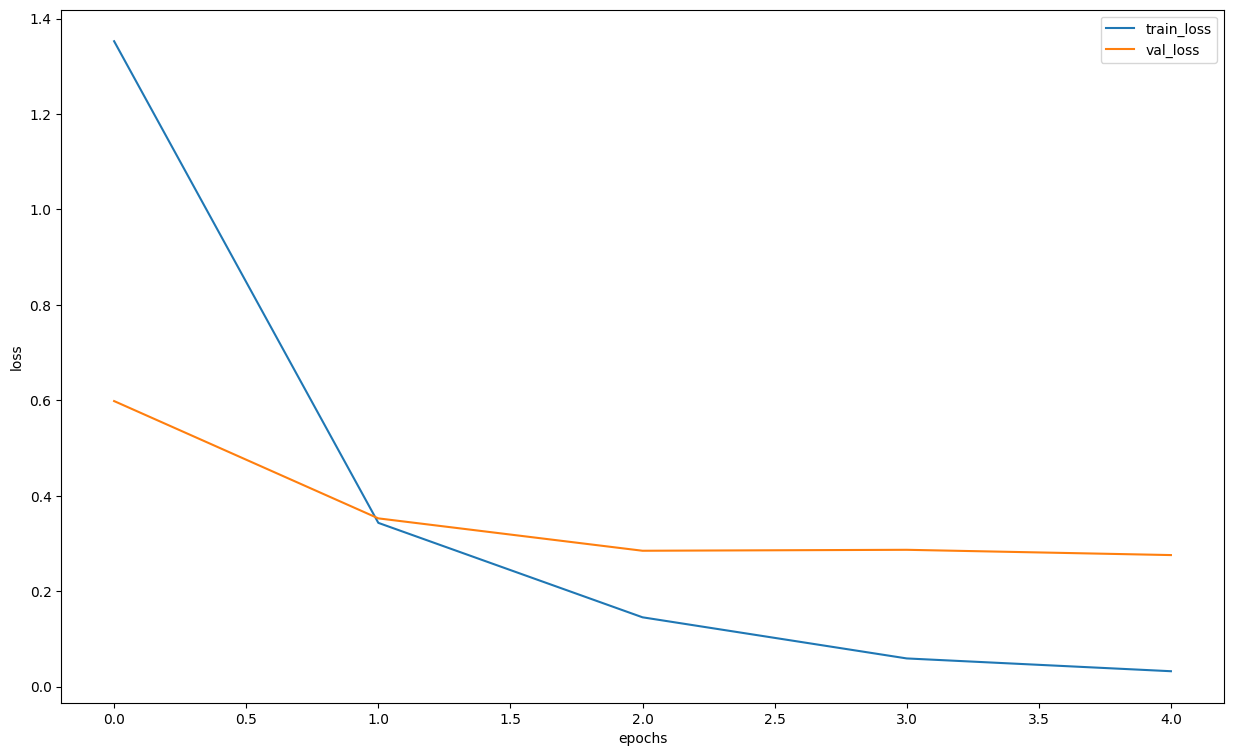

In [71]:
history = train(train_dataset, val_dataset, unfreezed_resnet18, NUM_EPOCHS, BATCH_SIZE, optimizer, LR_GAMMA)

In [75]:
eval_f1_score(unfreezed_resnet18, val_dataset)

0.9325563622468476

### 4.3. ResNet50 с размороженными последними слоями.

In [88]:
# Параметры обучения
NUM_EPOCHS = 3
BATCH_SIZE=128
LEARNING_RATE=0.0001
LR_GAMMA=1.0

In [89]:
unfreezed_resnet50 = torchvision.models.resnet50(pretrained=True)

for param in unfreezed_resnet50.parameters():
    param.requires_grad = False

unfreezed_resnet50.fc = nn.Linear(2048, n_classes)

for param in unfreezed_resnet50.layer4.parameters():
    param.requires_grad = True

for param in unfreezed_resnet50.avgpool.parameters():
    param.requires_grad = True
    

unfreezed_resnet50 = unfreezed_resnet50.to(DEVICE)

optimizer = torch.optim.Adam(unfreezed_resnet50.parameters(), lr=LEARNING_RATE, weight_decay=0.0015)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 1.060204810910608


epoch:  33%|███▎      | 1/3 [02:49<05:39, 169.72s/it]


Epoch 001 train_loss: 1.0602     val_loss 0.3816 train_acc 0.7764 val_acc 0.9213
loss 0.2571949599261754


epoch:  67%|██████▋   | 2/3 [05:36<02:47, 167.82s/it]


Epoch 002 train_loss: 0.2572     val_loss 0.2788 train_acc 0.9336 val_acc 0.9343
loss 0.10846598523584883


epoch: 100%|██████████| 3/3 [08:23<00:00, 167.90s/it]



Epoch 003 train_loss: 0.1085     val_loss 0.2359 train_acc 0.9728 val_acc 0.9459


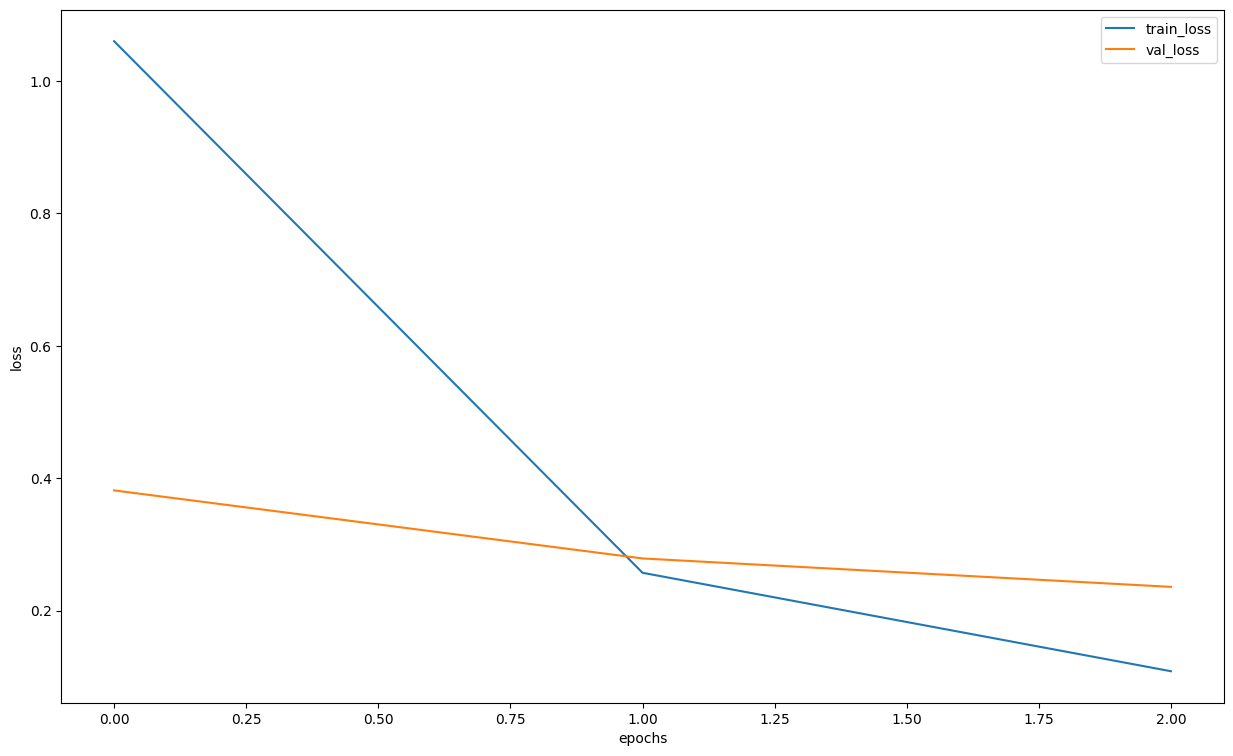

In [90]:
history = train(train_dataset, val_dataset, unfreezed_resnet50, NUM_EPOCHS, BATCH_SIZE, optimizer, LR_GAMMA)

In [91]:
eval_f1_score(unfreezed_resnet50, val_dataset)

0.945930454719144

## 5. Работа с данными. Аугментация.

### 5.1. Исследуем распределение классов.

In [19]:
classes_counter = dict()

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

for class_name in set(train_val_labels):
    classes_counter[class_name] = 0

for image in train_val_files:
    classes_counter[image.parent.name] += 1

classes_counter

{'moe_szyslak': 1452,
 'troy_mcclure': 8,
 'kent_brockman': 498,
 'marge_simpson': 1291,
 'charles_montgomery_burns': 1193,
 'comic_book_guy': 469,
 'homer_simpson': 2246,
 'principal_skinner': 1194,
 'mayor_quimby': 246,
 'otto_mann': 32,
 'barney_gumble': 106,
 'fat_tony': 27,
 'milhouse_van_houten': 1079,
 'gil': 27,
 'apu_nahasapeemapetilon': 623,
 'martin_prince': 71,
 'selma_bouvier': 103,
 'nelson_muntz': 358,
 'sideshow_mel': 40,
 'groundskeeper_willie': 121,
 'carl_carlson': 98,
 'patty_bouvier': 72,
 'waylon_smithers': 181,
 'chief_wiggum': 986,
 'lisa_simpson': 1354,
 'edna_krabappel': 457,
 'cletus_spuckler': 47,
 'lionel_hutz': 3,
 'abraham_grampa_simpson': 913,
 'miss_hoover': 17,
 'rainier_wolfcastle': 45,
 'bart_simpson': 1342,
 'professor_john_frink': 65,
 'krusty_the_clown': 1206,
 'snake_jailbird': 55,
 'ralph_wiggum': 89,
 'disco_stu': 8,
 'ned_flanders': 1454,
 'maggie_simpson': 128,
 'sideshow_bob': 877,
 'lenny_leonard': 310,
 'agnes_skinner': 42}

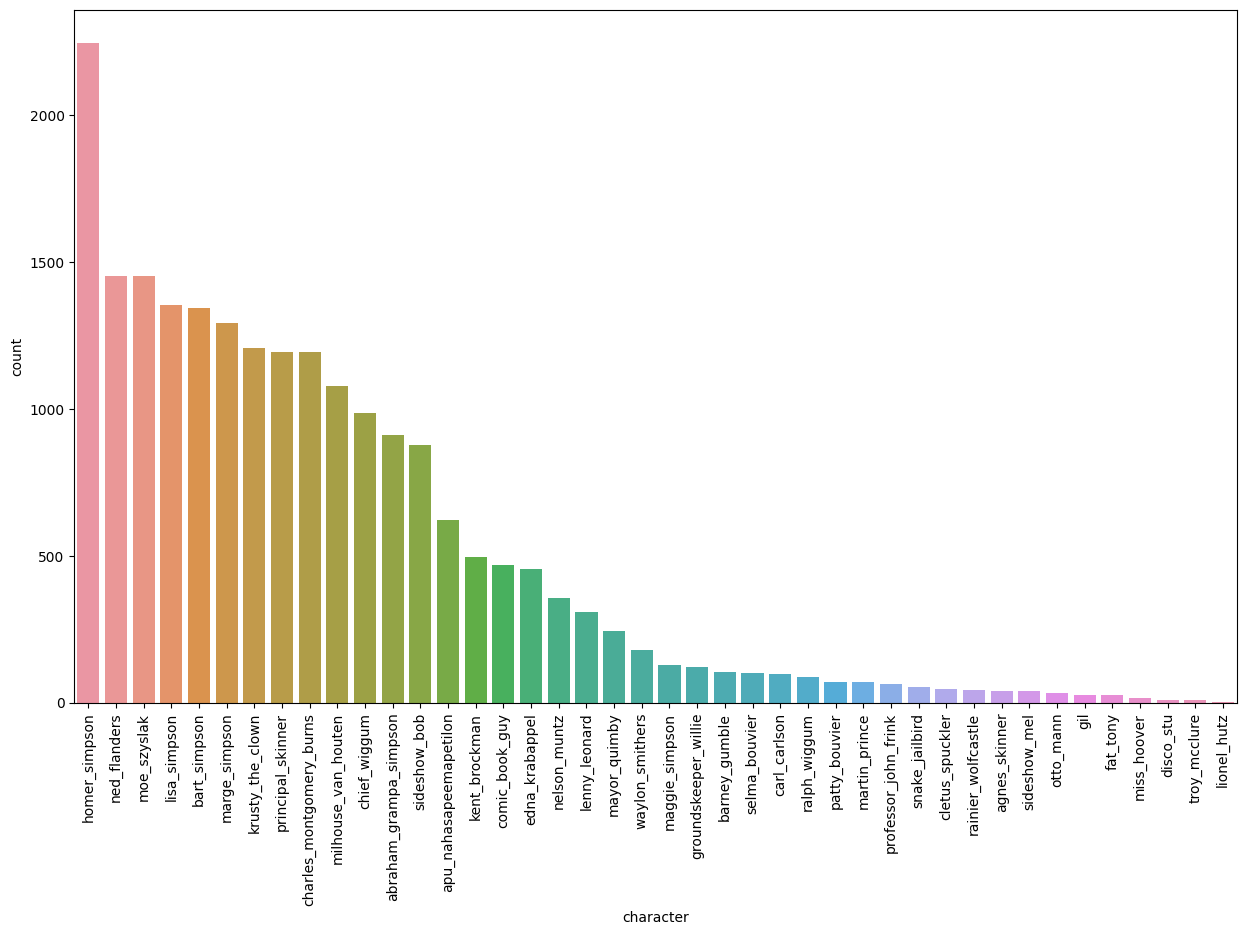

In [20]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(np.array(train_val_labels).reshape((-1, 1)), columns=['character'])

plt.figure(figsize=(15, 9))
sns.countplot(df, x='character', 
              order=df['character'].value_counts().index).set_xticklabels(df['character'].value_counts().index, 
                                                                                             rotation=90);

__Вывод:__ в данных присутствует очень сильный дисбаланс классов, некоторые классы содержат единицы примеров. Для улучшения ситуации добавим каждому редкому классу примеров при помощи аугментации. Редкими считаем те классы, в которых <500 примеров. Будем добавлять аугментированные данные в класс, пока не станет 500 примеров.

### 5.2. Добавим примеров на редкие классы при помощи аугментации.

In [21]:
!cp -r "/kaggle/input/simpsons/train/simpsons_dataset" "./"

In [22]:
TRAIN_DIR = Path('/kaggle/working/simpsons_dataset/')

In [25]:
import os

In [26]:
import random

def add_examples(class_name, add_num):
    """
    Пока не добавим add_num новых изображений в цикле будем
    случайно выбирать картинку из каталога, а затем выполнять случайное
    преобразование над ней, получая новую картинку
    """
    dir = Path(os.path.join(TRAIN_DIR, class_name))

    image_transforms = [
        transforms.Compose([transforms.Resize(size=300, max_size=301),
                            transforms.CenterCrop(size=300),
                            transforms.RandomCrop(250)]),
        transforms.RandomRotation(degrees=(-30, 30)),
        transforms.RandomHorizontalFlip(p=1)
    ]
    
    for i in range(add_num):
        files = sorted(list(dir.rglob('*.jpg')))
        # выбор случайного файла
        cur_file = random.choice(files)

        # выбор случайного преобразования
        cur_transform = random.choice(image_transforms)
        
        # проведение случайного преобразования и сохранение новой картинки
        # под новым именем!
        image = Image.open(cur_file)

        image.load()

        new_image = cur_transform(image)

        index = min_count_examples - add_num + i

        new_image.save(f"{dir}/pic_0{index}.jpg")

In [27]:
min_count_examples = 500

for i in classes_counter:
    if classes_counter[i] < min_count_examples:
        add_examples(i, 500 - classes_counter[i])

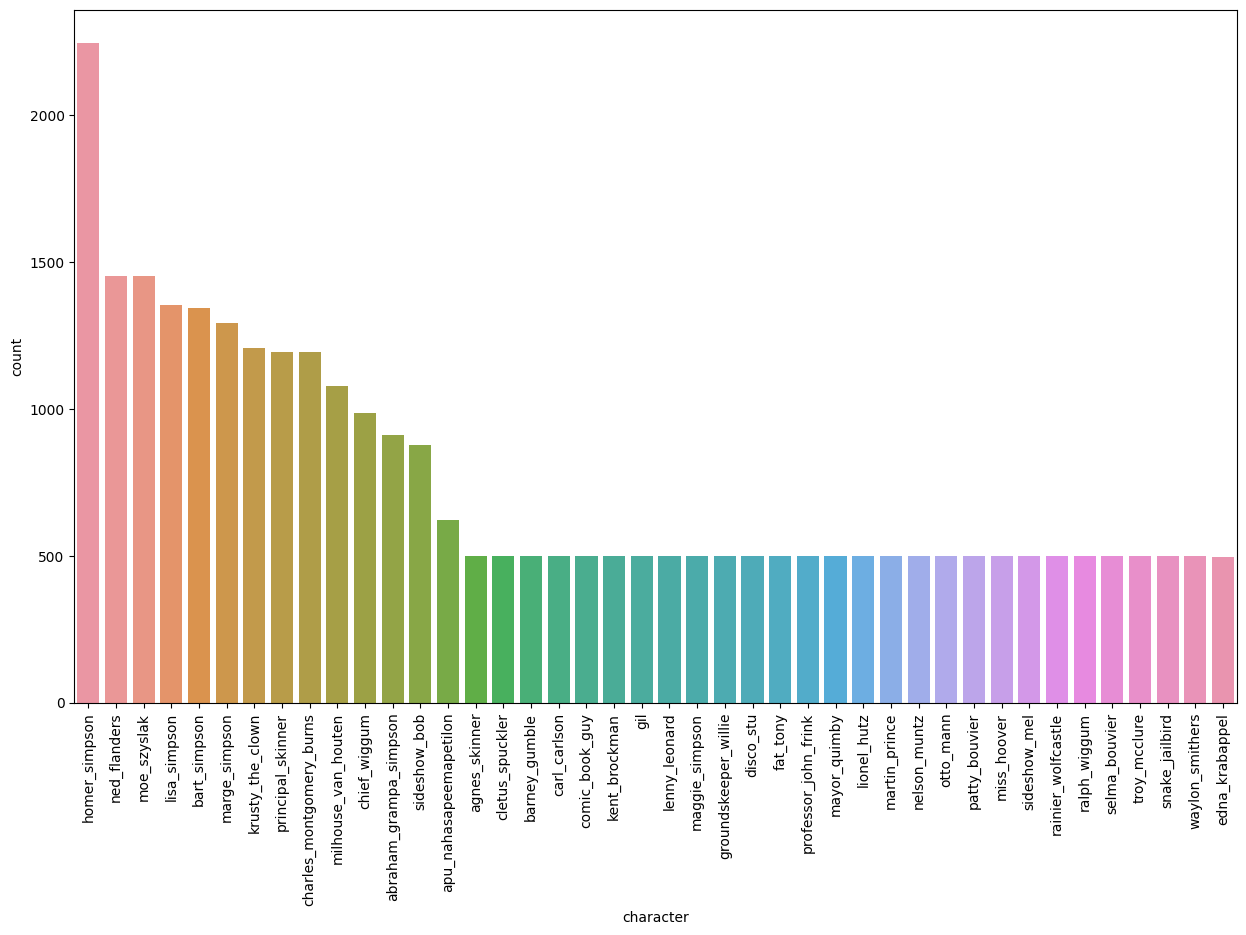

In [28]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

df = pd.DataFrame(np.array(train_val_labels).reshape((-1, 1)), columns=['character'])

plt.figure(figsize=(15, 9))
sns.countplot(df, x='character', 
              order=df['character'].value_counts().index).set_xticklabels(df['character'].value_counts().index, 
                                                                                             rotation=90);

### 5.3. Обучение модели на аугментированном датасете.

__Используемая модель:__ буду обучать полностью размороженную ResNet50. Причем так как данных теперь стало значительно больше, а сам ResNet50 уже хорошо обучен, буду обучать только 3 эпохи, дабы не сильно поменять веса в первых слоях ResNet50 (если переусердствовать, то качество падает). 

In [29]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels, random_state=42)

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


val_dataset = SimpsonsDataset(val_files, mode='val', transform=transform)


train_dataset = SimpsonsDataset(train_files, mode='train', transform=transform)

In [30]:
# Параметры обучения
NUM_EPOCHS = 3
BATCH_SIZE=256
LEARNING_RATE=0.0001
LR_GAMMA=0.5

In [31]:
n_classes = len(np.unique(train_val_labels))

In [32]:
final_resnet50 = torchvision.models.resnet50(pretrained=True)

for param in final_resnet50.parameters():
    param.requires_grad = True

final_resnet50.fc = nn.Linear(2048, n_classes)

final_resnet50 = final_resnet50.to(DEVICE)

optimizer = torch.optim.Adam(final_resnet50.parameters(), lr=LEARNING_RATE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s] 


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.5858801409034283


epoch:  33%|███▎      | 1/3 [04:38<09:16, 278.27s/it]


Epoch 001 train_loss: 0.5859     val_loss 0.1093 train_acc 0.8743 val_acc 0.9758
loss 0.08702523187991787


epoch:  67%|██████▋   | 2/3 [09:08<04:33, 273.73s/it]


Epoch 002 train_loss: 0.0870     val_loss 0.1578 train_acc 0.9772 val_acc 0.9637
loss 0.01850392541112885


epoch: 100%|██████████| 3/3 [13:38<00:00, 272.95s/it]



Epoch 003 train_loss: 0.0185     val_loss 0.1052 train_acc 0.9950 val_acc 0.9776


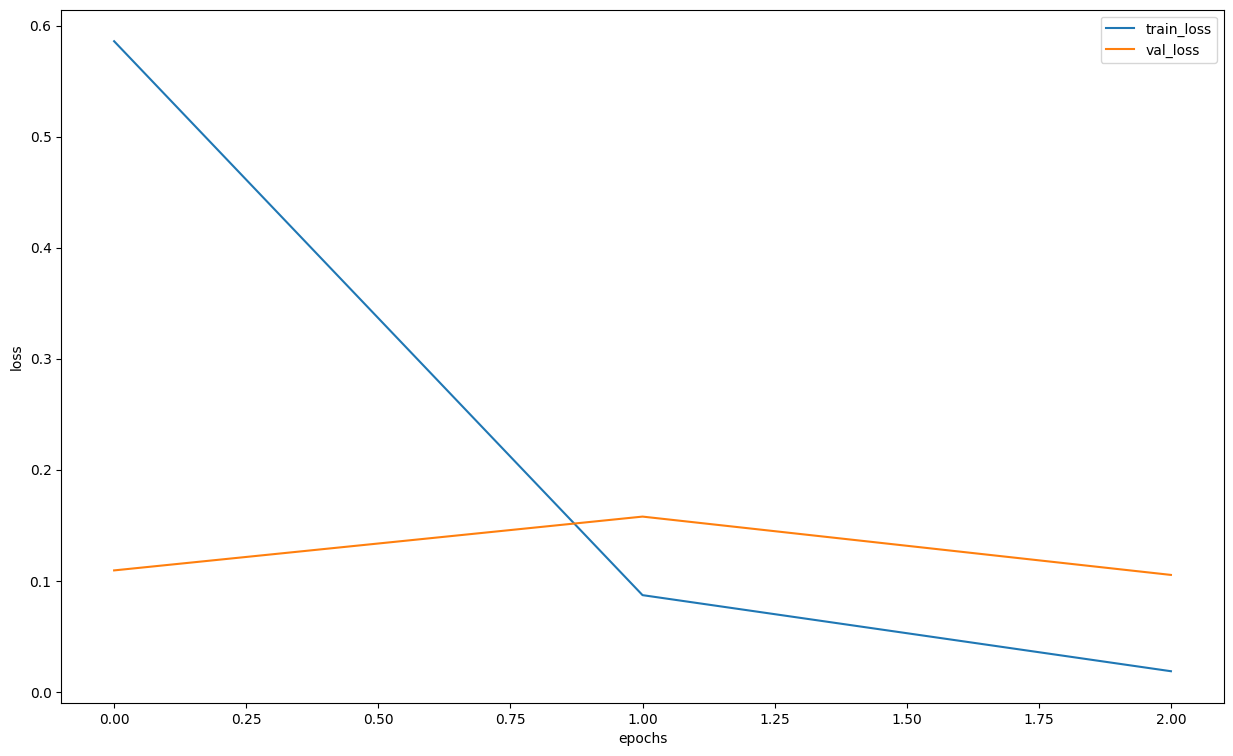

In [33]:
history = train(train_dataset, val_dataset, final_resnet50, NUM_EPOCHS, BATCH_SIZE, optimizer, LR_GAMMA)

## 6. Анализ результатов и submit на Kaggle.

Из всех проделанных экспериментов, наилучший результат показал полностью размороженный ResNet50, обученный на аугментированном датасете в течение 3-х эпох. 

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))


test_dataset = SimpsonsDataset(test_files, mode="test", transform=transform)

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(final_resnet50, test_loader)





preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]


In [36]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [37]:
my_submit.to_csv('final_resnet50(2).csv', index=False)

## Результат на Kaggle: 0.98512